# Ch13. Parallelizing Neural Network Training with Theano

** 발표자 : 정지원**

   이전 장에서 어떻게 인공신경망과 멀티레이어 퍼셉트론이 feedforward 하는지 수학적인 개념에 대해 다뤘다. 머신 러닝 알고리즘의 수학적인 기반을 먼저 이해하는 것은 매우 중요하다. 왜냐하면 이런 이해를 통해 매우 효과적이고 올바르게 알고리즘을 사용할 수 있다. 이전 챕터들에서 밑바닥부터 머신러닝의 best practice와 알고리즘 구현을 배웠다. 이번 장에서는 편안한 마음으로 머신러닝 연구원들이 딥뉴럴넷의 실험과 학습에 매우 유용하게 사용하는 강력한 라이브러리에 대해 살펴보겠다. 최근 머신러닝 연구는 **GPU**를 사용한다. 딥러닝에 관심이 있다면, 이번 챕터는 당신의 것이다. GPU사용은 옵션이니 걱정마라.

#### 다음 내용을 배운다.

    • Writing optimized machine learning code with Theano
    
    • Choosing activation functions for artificial neural networks
    
    • Using the Keras deep learning library for fast and easy experimentation

--------------------------------------------------------------------------------

## Building, compiling, and running expressions with Theano

이번 섹션에서는, 파이썬을 통해 매우 효과적으로 머신러닝 모델 학습을 해주는 강력한 **Theano tool**에 대해 배운다.

The Theano development started back in 2008 in the LISA lab (short for Laboratoire d'Informatique des Systèmes Adaptatifs (http://lisa.iro.umontreal.ca)) lead by Yoshua Bengio.

Theano에 대해 배우기 전에, 우리가 머신러 속도를 높이기 위해 무엇을 할지 살펴보자. 우리가 매우 많은 연산을 할 때의 문제에 대해 얘기해보자. 운좋게도 컴퓨터 프로세서의 성능은 해가갈수록 꾸준히 좋아지고 있다. 이 때문에 우리가 머신러닝 모델의 예측 성능을 향상시키기 위한 강력하고 복잡한 학습 시스템을 만들 수 있다. 이전 챕터에서, 싸이킷-런의 많은 함수들이 다수의 프로세싱 유닛에 계산을 분산시켜줬다. 그러나 기본적으로 파이썬은 ** Global Interpreter Lock** 때문에 one core의 실행에 제한돼있다. 하지만 비록 우리가 _multiprocessing_ 라이브러리의 이점이 있더라도, 좋은 데스크탑의 경우도 8/16 이상의 코어를 갖는게 거의 없다는 사실을 고려해야한다.

이전 챕터로 돌아가서, 히든 레이어를 하나 갖는 50개 units의 아주 단순한 멀티레이어 퍼셉트론을 생각해보자. 매우 단순한 이미지 분류 문제를 위해 대략 1000 weights를 최적화시켜야 했다. **MNIST**의 이미지는 다소 작았지만, 만약에 히든레이어가 하나 추가되고 이미지가 높은 픽셀밀도를 가졌다고 상상해보자. 이러한 작업은 single processing unit으로는 실행할 수 없게 될 것이다. 이제 문제는 이러한 문제를 어떻게 효과적으로 다룰지이다. 좋은 방법으로는 GPU를 사용하는 것이다. GPU는 real power horses다. 그래픽 카드를 당신 기계 안의 작은 컴퓨터 클러스터로 보면 된다. 최근 GPU의 장점은 최신 CPU와 비교했을때 상대적으로 저렴한 것이다.

![Image](figures/1.png)

(date : August 20, 2015)

CPU의 70% 가격으로 GPU에서 450배의 코어를 얻을 수 있다. 초당 15배의 부동소수점 연산이 가능하다. 이제 문제는, GPU을 target하기 위한 코드를 적는 것은, 파이썬 코드를 실행하는 것과 같이 하찮은 것이 아니다. __CUDA__와 __OpenCL__과 같은 특별한 패키지들은 GPU 타겟하는 것을 도와줄것이다. 그러나 __CUDA__나 __OpenCL__와 같은 코드를 입력하는 것은 아마 머신러닝 알고리즘을 실행하는데 가장 좋은 환경은 아닐 것이다. 더 좋은 소식은 __Theano__가 개발된 것이다.

--------------------------------------------------------------------------

## What is Theano?

정확히 Theano가 뭐냐? 컴퓨터 언어? 컴파일러? 파이썬 라이브러리?

이 모든 표현이 말이 된다. Theano는 다중차원의 array에 강력하게 초점을 맞춰 실행하고, 컴파일하고, 수학적 표현을 계산하는데 매우 효과적이다. CPU로 코드를 돌리는 옵션도 있다. 그러나 GPU를 사용하는 것이 큰 메모리 대역폭의 장점과 뛰어난 부동소수점 계산의 능력의 이점을 얻을 것이다. Theano를 이용하여 메모리 공유를 동시에 하는 코드를 쉽게 실행할 수 있다. 2010년도에, CPU 사용에서 Theano는 NumPy보다 1.8배 빠른 성과를 보였다. GPU에서는 11배 빠른 속도를 보였다. Theano의 성능과 그래픽카드의 성능은 상당히 개선되어왔다.

NumPy가 Theano랑 무슨 관련이 있는가? Theano는 NumPy 기반으로 만들어졌다. 그리고 매우 유사한 구문을 사용하며, 이런 언어에 친숙한 사람들에게 편리성을 준다. Theano는 많은 사람들이 언급하는 "NumPy on steroids" 뿐만 아니라, SymPy와의 몇몇 유사성을 공유하기도 한다. SymPy는 symbolic computation(or symbolic algebra)을 제공하는 파이썬 패키지다. 이전장에서 봤듯이, NumPy에서 변수를 정의하고 원하는 방식으로 조합했다. 그리고 코드는 줄줄이 실행됐다. 하지만 Theano에서는, 문제를 먼저 적고, 우리가 어떻게 분석하기를 원하는지 적는다. 그러면 Theano가 코드를 컴파일 하고 최적화 시켜준다. 최적화된 코드를 작성하기 위해서 Theano는 우리 문제의 범위를 알아야만 한다. 이것을 tree of operations라고 생각해봐라.(혹은 상징적 표현의 그래프) Theano는 여전히 개발되는 중으로 많은 기능들이 추가되었고, 이러한 발전은 정기적으로 이루어진다. 이번 챕터에서, 우리는 Theano의 기본 개념에 대해 알아보고, 어떻게 머신러닝을 수행하는데 사용되는지 배울 것이다. Theano는 많은 고급기능을 가진 라이브러리기 때문에, 다 다루기는 힘들다. 다음 링크에서 더 배울 수 있다.

(http://deeplearning.net/software/theano/)

-----------------------------------------------------------------------------------

## First steps with Theano

설치 방법,

__pip install Theano__

Theano는 core에 상징화된 수식 표현을 계산하기 위한 tensor를 내장하고 있다. 텐서는 스칼라, 벡터, 행렬 등으로 이해될 수 있다. 구체적으로, 스칼라는 rank-0 텐서이며, 벡터는 rank-1 텐서, 행렬은 rank-2 텐서이다. 그리고 3차원으로 만들어진 행렬들은 rank-3 텐서이다. 간단한 스칼라를 사용하기 위해 _tensor_ 모듈을 사용해보자. z를 계산하기 위해, sample point x와 weight w1과 bias w0을 구해보자. 

![Image](figures/2.png)

In [1]:
import theano
from theano import tensor as T
# initialize
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0
# compile
net_input = theano.function(inputs=[w1, x1, w0],outputs=z1)
# execute
print('Net input: %.2f' % net_input(2.0, 1.0, 0.5))

Net input: 2.50


이것은 매우 직관적이다. Theano에서 코드를 작성한다면, 다음 세 가지 간단한 과정을 따르기만 하면 된다. 1)_symbols_를 정의하고, 2)code를 컴파일하고, 3)실행한다. 시작 단계에서, z를 구하기 위해 x1, w1, w0 세 가지 심볼을 정의했다. 그리고 net input z1을 계산하기 위해 _net_input_ 함수를 컴파일했다.

그러나 Theano 코드를 작성할 때, 한 가지 특별히 주의해야 할 것이 있다. 변수의 타입이다. 좋아할 일이든 아니든간에 64/32 bit integer나 float 중에 어떤 것을 사용하고 싶은지 선택해야 한다. 이것은 코드의 성능에 매우 영향을 주기 때문에 다음 섹션에서 더 알아보자.

----------------------------------------------------------------------------------

## Configuring Theano

요즘, 맥OS든 리눅스든 윈도우든 상관 없이, 소프트웨어나 어플리케이션들은 주로 64bit 메모리 주소를 이용한다. 그러나 우리가 GPU에서 수학적 표현을 계산을 가속화하기 위해서는, 우리는 32bit 메모리주소에 의존해야만 한다. 최근에는, Theano에서 오직 이 컴퓨팅 구조만을 지원해준다. 이번 섹션에서, Theano를 어떻게 구성하는지 볼 것이다. 만약 더 세부적으로 알고 싶다면, 다음을 참고해라.
(http://deeplearning.net/software/theano/library/config.html. )

머신러닝 알고리즘을 구현할 때, 대부분 부동소수점수를 이용한다. 기본적으로, NumPy와 Theano는 _double-precision flaoting-point numbers_(float64)를 사용한다. 하지만 CPU에서 코드를 짜고 GPU에서 실행 시킬때는 float64와 float32를 앞뒤로 전환하는 것이 유용할 것이다. 예를 들어, Theano의 flaot 변수를 기본적으로 설정하기 위해 다음과 같은 코드를 입력하면 된다.

In [2]:
print(theano.config.floatX)

float64


셋팅을 바꾸고 싶으면, 다음과 같이 입력한다.

In [3]:
theano.config.floatX = 'float32'

In [4]:
print(theano.config.floatX)

float32


Theano에서 GPU를 이용할 때, float32를 필요로 하지만, CPU에서 float64와 float32 모두 사용 가능하다. 그러므로 Command-line terminal를 통해 다음과 같이 _THEANO_FLAGS_의 세팅을 바꿀 수 있다.

*export THEANO_FLAGS=floatX=float32*

혹은 특정 파이썬 스크립트에만 적용하고자 한다면 다음과 같이 입력하면 된다.

*THEANO_FLAGS=floatX=float32 python your_script.py*

CPU와 GPU 실행 사이의 전환하는 옵션에 대해 알아보자. 다음 코드를 통해 확인부터 해보자.

In [5]:
print(theano.config.device)

cpu


개인적인 추천으로는, 코드를 만들고 디버깅하기 쉽기 때문에 _cpu_를 기본으로 사용해라. 만약 command-line terminal에서 CPU로 실행하고 싶다면 다음과 같이 실행해라.

*THEANO_FLAGS=device=cpu,floatX=float64 python your_script.py*

그러나 일단 코드를 구현하고 GPU를 사용해 효율적으로 돌아가게 하고싶다면, 우리 원래 코드를 추가적으로 수정하지 않고도 다음 코드를 통해 실행시킬 수 있다.

*THEANO_FLAGS=device=gpu,floatX=float32 python your_script.py*

_.theanorc_ 파일을 home directory에 만들어서 영구적으로 이러한 구성을 할 수도 있다. 예를 들어, 항상 float32와 GPU를 사용하고자 한다면 다음과 같은 _.theanorc_ 파일을 세팅해라. 명령어는 다음과 같다.

*echo -e "\n[global]\nfloatX=float32\ndevice=gpu\n" >> ~/.theanorc*

맥이나 리눅스를 사용하지 않는다면, 좋아하는 텍스트 에디터를 통해 다음과 같이 입력하여 수동으로 _.theanorc_ 파일을 만든다.

_[global]
floatX=float32
device=gpu_

이제 대충 어떻게 하드웨어에 대해 Theano를 구성하는지 알았다. 이제 더 복잡한 array 구조를 보자.

----------------------------------------------------------------------

## Working with array structures

이번 섹션에서는, _tensor_모듈을 이용하여 Theano의 array 구조를 사용하는 방법을 배운다. 다음 코드를 실행하면, 2x3 행렬을 얻을 수 있다. Theano의 최적화된 텐서 표현을 통해 열의 합을 계산해보자.

In [6]:
import numpy as np
# initialize
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)
# compile
calc_sum = theano.function(inputs=[x], outputs=x_sum)
# execute (Python list)
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

('Column sum:', array([ 2.,  4.,  6.], dtype=float32))


In [7]:
# execute (NumPy array)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

('Column sum:', array([ 2.,  4.,  6.], dtype=float32))


앞서 봤듯이, 3가지 간단한 과정을 통해 Theano를 이용할 수 있다. 변수의 정의, 코드의 compiling, 실행. 다음 예시는 Python과 NumPy의 자료형에서 Theano가 어떻게 작용하는지 보여준다.

In [8]:
print(x)

x


In [9]:
print(x.type())

<TensorType(float32, matrix)>


Theano는 매우 똑똑한 메모리 운영 시스템을 가지고 있어서 메모리를 재사용하기 때문에 속도가 빠르다. 메모리 공간을 여러 장치에 분산시키고, 각각의 버퍼에 별칭을 준다. 이제, 큰 object(arryas)를 분산해주고 여러 함수가 접근을 읽고 쓸 수 있게 부여해주는 _shared_ 변수에 대해 알아보자. 편집한 후에 이러한 object에 대한 업데이트를 수행할 수 있다. Theano에서 메모리 핸들링에 대해 더 자세히 설명하는 것은 이 책의 범위를 넘는다.

그러므로 메모리 운용에 대해 알고 싶다면 다음을 봐라.
http://deeplearning.net/software/theano/tutorial/aliasing.html.

In [10]:
# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX)) # shared => GPU의 메모리로 카피해서 효율적으로
# 하이퍼 파라미터 같은거는 다 SHARED로 걸어넣고 GPU 안에서 업데이트!
# cpu 모드는 노상관이지만,,, gpu 메모리로 옮겨하는 시간이 매우 비효율적이기 때문에 이런 것이 필요
# 실제 데이터와 symbolic으로 독립시켜놓는 이유가 또한 GPU다. (tf 또한)

z = x.dot(w.T)
update = [[w, w + 1.0]] # 가중치?!
# compile
net_input = theano.function(inputs=[x], updates=update, outputs=z)
# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

('z0:', array([[ 0.]], dtype=float32))
('z1:', array([[ 6.]], dtype=float32))
('z2:', array([[ 12.]], dtype=float32))
('z3:', array([[ 18.]], dtype=float32))
('z4:', array([[ 24.]], dtype=float32))


보다시피 메모리 공유는 매우 간단하다. 앞선 예제에서 _update_ 변수를 통해 array를 각 이터레이션마다 1씩 업데이트 하는 것으로 정의했다. 어떤 object를 업데이트 할 것이고, 어떻게 할지 정해준 후에 _theano.function_ 에 들어있는 _update_ 파라미터에 정보를 전달한다.

_givens_ 변수 역시 Theano에서 사용하기 좋다. 이는 컴파일링 하기전에 값을 그래프로 삽입해준다. 이 방법을 사용하면, RAM에서 CPU를 통해 GPU로 이동되는 수를 줄여서 공유변수를 이용하는 학습 알고리즘의 속도를 빠르게 할 수 있다. 우리가 데이터셋을 경사하강 하는 동안 여러 번 iterate 하듯이, 만약 _inputs_ 파라미터를 사용한다면, 데이터는 CPU에서 GPU로 여러 번 전송된다. _givens_를 이용하여 메모리에 데이터셋이 맞다면(fit), GPU에 데이터셋을 유지할 수 있다. 코드는 다음과 같다.

In [11]:
# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]
# compile
net_input = theano.function(inputs=[],
updates=update,
givens={x: data},
outputs=z)
# execute
for i in range(5):
    print('z:', net_input())

('z:', array([[ 0.]], dtype=float32))
('z:', array([[ 6.]], dtype=float32))
('z:', array([[ 12.]], dtype=float32))
('z:', array([[ 18.]], dtype=float32))
('z:', array([[ 24.]], dtype=float32))


_givens_의 속성은 파이썬 dictionary과 같다. 여기서, _fmatrix_를 정의할 때, 이름을 설정했다.

------------------------------------------------------------------------------

## Wrapping things up – a linear regression example

이제 좀 친숙해졌으니, __Ordinary Least Squares (OLS) __ regression을 해보자.

다음과 같이 1차원 toy dataset을 만든다.

In [12]:
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0], [5.0],
                      [6.0], [7.0], [8.0], [9.0]],dtype=theano.config.floatX)

In [13]:
y_train = np.asarray([[1.0], [1.3], [3.1], [2.0], [5.0], [6.3],
                      [6.6], [7.4], [8.0], [9.0]],dtype=theano.config.floatX)

선형회귀모델의 weight를 학습시키기 위해 training function을 구현해보자.SSE cost function을 이용한다. w0는 bias임을 명심해라. 코드는 다음과 같다.

In [14]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):
    
    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y')
    X = T.fmatrix(name='X')
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1),
                               dtype=theano.config.floatX), name='w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))
    
    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]
    
    # compile model
    train = theano.function(inputs=[eta0], outputs=cost, updates=update,
                            givens={X: X_train, y: y_train,})
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

Theano의 매우 좋은 기능은, _grad_ function 이다. _grad_ function은 _wrt_ argument를 사용함으로써 파라미터와 관련한 미분된 식을 자동으로 계산해준다.

training function을 구현한 후에, 실제 선형회귀모델을 train해보자. SSE를 살펴보면서 비용 함수가 수렴하는지 확인해보자.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

TypeError: Cannot convert Type TensorType(float32, matrix) (of Variable <TensorType(float32, matrix)>) into Type TensorType(float32, vector). You can try to manually convert <TensorType(float32, matrix)> into a TensorType(float32, vector).

5 번째 epoch 이후 수렴한 것을 알 수 있다.

여태까지는 그런대로 잘 됐다. 비용함수를 보면, 특정 데이터셋으로부터 회귀 모델을 만든 것 처럼 보인다. 이제, 새로운 함수를 컴파일해서 예측을 해보자.

In [54]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    return predict(X)

In [ ]:
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]),Parallelizing Neural Network Training with Theano,
         predict_linreg(X_train, w), color='gray',
         marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

보다시피 잘 fit 됐다. 간단한 회귀모델을 구현하는 것은 Theano API와 친숙해지기 좋다. 그러나 궁극적인 목표는 Theano의 장점을 끌어내는, 즉 강력한 인공신경망을 구현하는 것이다. Theano를 기반으로 한 필자가 가장 좋아하는 딥러닝 라이브러리를 소개한다. 이는 뉴럴 넷을 최대한 편하게 실험할 수 있게 해준다. 그러나 __Keras__ 라이브러리를 소개하기 전에, 뉴럴 넷의 activation 함수의 다른 선택에 대해 얘기해본다.

--------------------------------------------------------------------------

## Choosing activation functions for feedforward neural networks

간단하게 하기 위해서 여태까지는 multilayer feedforward 뉴럴 넷의 맥락에서 sigmoid 액티베이션 함수에 대해 얘기했다. Multilapyer perceptron에서 output layer와 hidden layer  모두 sigmoid를 사용했다. sigmoid 함수는 _logistic function_ 혹은 _negative log-likelihood function_ 이라고 하는게 정확하다. 멀티레이어 뉴럴넷을 향상시키기 위해 sigmoid 외에 대안을 알아보자.

기술적으로는, 우리는 미분가능한 액티베이션 함수를 사용할 수 있다. 혹은 Adaline과 같은 선형 activation 함수를 사용할 수도 있다. 그러나 실전에서는 hidden과 output layer에 선형 activation 함수를 이용하는 것은 매우 유용하지 않다. 왜냐면 복잡한 문제를 해결해주는 전형적인 뉴럴 넷에서 비선형성을 표현하고 싶기 때문이다. 선형함수의 합은 결국 선형함수를 얘기하게 된다.

로지스틱 액티베이션 함수는 뇌의 뉴런의 개념과 유사하다. 우리는 이것을 뉴런이 활성화 할지 아닐지에 대한 확률로 생각할 수 있다. 그러나 로지스틱 액티베이션 함수는 매우 큰 음수를 input으로 가질 때 문제가 될 수도 있다. 왜냐면 이런 경우에 sigmoid의 아웃풋이 0에 가까워지기 때문이다. 만약 sigmoid 함수가 아웃풋을 0에 가깝게 반환한다면, 뉴럴넷은 매우 느리게 학습할 것이고 학습하는 동안 local minima에 빠질 가능성이 높아진다. 그래서 사람들은 히든레이어에서 __hyperbolic tangent__ 를 사용하는 것을 선호한다. 우선, multi-class classification에서 로지스틱 함수의 개념을 다시 살펴보자.

----------------------------------------------------------------------------------

## Logistic function recap

이번 섹션에서는, sigmoid 함수라고 불리는 로지스틱 함수에 대해 살펴본다. 정확히는 sigmoid 함수의 특별한 케이스이다. Chp3에서 로지스틱 함수를 이용하여 sample x가 어느 class에 속하는지 확률을 모델링하였다.

![Image](figures/3.png)

여기 스칼라 변수인 z가 net input으로 다음과 같이 정의된다.

![Image](figures/4.png)

w_0은 bias unit임을 기억해라. 2차원 데이터 포인트 x와 weight coefficients 벡터 w를 갖는 모델을 가정해보자.

In [16]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


net input을 계산해서 특정 변수 값과 weight 계수를 통해 로지스틱 뉴런을 activate 하는데 사용했다면, 0.707을 얻을 것이다. 이것은 x가 positive class에 속할 가능성이 70.7%라는 것이다. Chp12에서는 멀티 클래스기 때문에 one-hot encoding을 사용하여 다중 로지스틱 액티베이션 단위가 존재하는 아웃풋레이어의 값을 구해냈다. 그러나 다음 코드에서 보다싶이, 다중 로지스틱 액티베이션 단위를 갖는 아웃풋레이어는 의미있고 해석이되는 확률 값을 제공하지 못한다.

In [18]:
# W : array, shape = [n_output_units, n_hidden_units+1]
# Weight matrix for hidden layer -> output layer.
# note that first column (A[:][0] = 1) are the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5], [0.1, 0.2, 0.4, 0.1], [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
# Activation of hidden layer.
# note that first element (A[0][0] = 1) is the bias unit
A = np.array([[1.0], [0.1], [0.3], [0.7]])

# Z : array, shape = [n_output_units, n_samples]
# Net input of the output layer.
Z = W.dot(A)
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

('Probabilities:\n', array([[ 0.87653295],
       [ 0.57688526],
       [ 0.90114393]]))


아웃풋에서 볼 수 있듯이, 확률은 특정 샘플이 첫 번째 클래스에 속할 확률이 대략 88%임을 뜻한다. 또한 2,3 번재 클래스에 속할 확률이 각각 58%, 90%임을 뜻한다. 이는 분명 혼란스럽다. 왜냐면 우리가 아는 확률의 합은 100%이기 때문이다. 그러나 이것은 사실 우리가 우리의 모델에서 정확히 class label을 알고싶은 경우에는 문제가 되지 않는다. 하지만 클래스에 속할 확률을 구할 때는 문제가 된다.

In [19]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


그러나, 특정 상황에서는, 이러한 멀티클래스 예측의 확률값을 주는 것이 매우 유용하다. 다음 장에서는 logistic function을 일반화한 __softmax__ 함수에 대해 알아본다.

----------------------------------------------------------------

## Estimating probabilities in multi-class classification via the softmax function

__softmax__ 함수는 로지스틱 함수의 일반화된 형태이다. 소프트맥스에선, net input z를 갖는 특정 샘플 x의가 _i_ 번째 class에 속할 확률을 모든 M 리니어 함수의 합인 분모로 정규화 식을 통해 계산한다.

![Image](figures/5.png)

In [20]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return sigmoid(z)

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

('Probabilities:\n', array([[ 0.40386493],
       [ 0.07756222],
       [ 0.51857284]]))


In [21]:
y_probas.sum()

1.0

보다싶이, 이제 합이 1이 된다. 또한 두 번째 클래스의 확률값이 0에 가까운 것을 알 수 있다. z_1과 max(z)의 차이가 크기 때문이다. 그러나 로지스틱 함수와 같은 label을 얻는 것을 볼 수 있다. 직관적으로 소프트맥스 함수는 멀티클래스 예측에서 의미있는 클래스-멤버 예측을 하기 위한 표준화된 로지스틱 함수라고 볼 수 있다.

In [22]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


------------------------------------------------------------------------------------------------

## Broadening the output spectrum by using a hyperbolic tangent

또다른 인공신경망의 히든레이어에서 자주 쓰이는 sigmoid 함수로는 __hyperbolic tangent__가 있다. 이것은 로지스틱 함수의 rescaled된 버전으로 해석될 수도 있다.

![Image](figures/new6.png)

하이퍼볼릭 탄젠트의 장점은 넓은 아웃풋 스펙트럼과 개구간 (-1,1)에 속한다는 것이다. 이것은 back propagation 알고리즘의 수렴을 증명해준다. 반대로 로지스틱 함수는 개구간 (0,1) 범위에 있는 하나의 output signal을 반환한다. 직관적으로 비교하기 위해 두 함수를 1차원 공간에 그려보자.

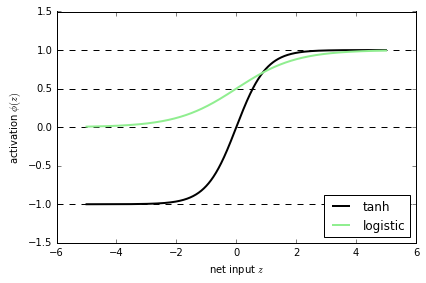

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, linewidth=2, color='black', label='tanh')
plt.plot(z, log_act, linewidth=2, color='lightgreen', label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

그리기 위해 로지스틱과 하이퍼볼릭탄젠트 함수를 자세히 구현했지만, NumPy의 tanh 함수는 다음과 같이 사용할 수도 있다.

In [24]:
tanh_act = np.tanh(z)

또한, 로지스틱 함수도 SciPy의 스페셜 모듈을 통해 이용 가능하다.

In [25]:
from scipy.special import expit
log_act = expit(z)

이제 우리는 인공신경망에서 자주 사용되는 여러 액티베이션 함수에대해 알아봤다. 다음 사진을 보며 이 섹션을 마무리한다.

![Image](figures/7.png)

-------------------------------------------------------

## Training neural networks efficiently using Keras

이번 섹션에서는, 뉴럴 넷의 학습을 촉진하기 위해 개발된 라이브러리중 가장 최근 것인 Keras에 대해 살펴본다. 2015년도 초기에 시작됐다. Theano를 기반으로 만들어진 라이브러리로, GPU가 뉴럴넷의 학습을 가속화시키는데 활용할 수 있다. 매우 직관적인 API라는 것이 특징이다. 불과 몇 줄의 코드로 뉴럴 넷을 구현할 수 있다. Theano가 깔려 있다면, Keras를 다음과 같이 설치한다.

__pip install Keras__

MNIST 데이터를 다운 받아서, 다음과 같이 실행해보자.

In [26]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

X_train, y_train = load_mnist('C:/Users/Administrator/mnist/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('C:/Users/Administrator/mnist/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

IOError: [Errno 2] No such file or directory: 'C:/Users/Administrator/mnist/train-labels.idx1-ubyte'

당신의 GPU를 사용하여 실행해보고 싶다면, 다음과 같이 command 명령어를 통해 실행해봐라.

__THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_keras_mlp.py__

이제 학습시키기 위해 MNIST 이미지 배열을 32-bit 형식으로 변환해보자.

In [29]:
import theano
theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

NameError: name 'X_test' is not defined

In [9]:
from keras.utils import np_utils
print('First 3 labels: ', y_train[:3])

Using TensorFlow backend.


ImportError: No module named 'tensorflow'

In [28]:
y_train_ohe = np_utils.to_categorical(y_train)
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

NameError: name 'np_utils' is not defined

이제 뉴럴넷을 구현해보자. Chp12와 같은 구조로 실행할 것이다. 그러나 히든레이어의 logistic 유닛을 하이퍼볼탄젠트 액티베이션 함수로 바꾸고, 아웃풋레이어의 로지스틱 함수를 소프트맥스로 바꿀 것이다. 또한 하나의 히든레이어를 추가한다. Keras는 이러한 작업들을 매우 간단하게 해준다.

In [27]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=50,
                init='uniform', activation='tanh'))


model.add(Dense(input_dim=50, output_dim=50, init='uniform',
                activation='tanh'))

model.add(Dense(input_dim=50, output_dim=y_train_ohe.shape[1],
                init='uniform', activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

Using TensorFlow backend.


NameError: name 'y_train_ohe' is not defined

우선 _Sequential_ 클래스를 이용하여 feedforward 신경망을 구현할 새로운 모델을 만든다. 그러고서 많은 레이어를 추가한다. 그러나 우리는 처음에 input 레이어를 추가했으므로, input_dim 는 트레이닝 셋의 feature의 수와 같은지 확인해줘야한다. 또한 두 연속적인 레이어의 아웃풋 unit의 수와 input unit가 같은지 봐줘야한다. 예시에서는 두개의 히든레이어에 50개의 히든 유닛과 1개의 bias 유닛을 각각 넣어줬다. Keras에서 완벽히 연결된 네트워크에서는 bias unit은 0으로 초기화된다. 이것은 bias unit을 1로 초기화했던 MLP를 구현할 때와 비교된다. 1로 하는게 일반적이다.

끝내, 아웃풋 레이어의 유닛의 수는 특정 클래스 label의 수와 같아져야만 한다. one-hot encode된 클래스 label의 열의 합이다. 모델을 컴파일하기 전에, optimizer를 정의해야만 한다. 지난 예시에서 SGD를 사용하였으니 이번에도 그렇게 해보자. 각각의 epoch마다 학습률을 적용하기 위해 weight decay constant를 정의할 수도 있다. _categorical_crossentropy_ 를 통해 비용함수를 정의한다. 교차 엔트로피는 단순히 로지스틱 회귀에서 비용함수 위한 테크니컬한 용어이며 __범주형 cross-entropy__는 소프트맥스를 통해 멀티 클래스 예측을 하기 위한 일반화된 것이다. 모델을 컴파일한 후에, fit 메소드를 이용하여 학습을 할 수 있다. 여기서는, 300개의 트레이닝 샘플의 batch 사이즈를 이용하는 mini-batch stochastic gradient를 이용한다. MLP를 50번 반복하여 학습시키며, verbose=1로 세팅 함으로써 비용 함수의 최적화를 따라가본다. _validation_split_ 파라미터는 특히 능숙한데, 이것은 각각의 에폭 후에 검증을 위해 10%의 학습데이터를 반전시킨다. 따라서 학습동안 오버피팅 되는 경우를 확인할 수 있다.

In [10]:
model.fit(X_train, y_train_ohe, nb_epoch=50, batch_size=300, verbose=1,
          validation_split=0.1, show_accuracy=True)

NameError: name 'model' is not defined

학습시키는 동안 비용함수의 값을 출력하는 것은 매우 유용하다. 비용이 갑자기 줄어드는 구간을 찾아내거나, 찾지 못한다면 하이퍼파라미터를 tune하기위해 알고리즘을 종료할 것이다.

클래스 레이블을 예측하기 위해, 우리는 _predict_classes_ 메소드를 사용하였고, 이것은 class label을 정수로 정확히 반환한다.

In [3]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

NameError: name 'model' is not defined

In [ ]:
train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

In [ ]:
y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

파라미터 최적화 튜닝하지 않은 아주 간단한 뉴럴넷을 보았다. Kears에 대해 더 알고 싶다면 다음을 참조해라.

Although Keras is great library for implementing and experimenting with neural networks, there are many other Theano wrapper libraries that are worth mentioning. A prominent example is Pylearn2 (http://deeplearning.net/software/pylearn2/), which has been developed in the LISA lab in Montreal. Also, Lasagne (https://github.com/Lasagne/Lasagne) may be of interest to you if you prefer a more minimalistic but extensible library, that offers more control over the underlying Theano code.